# Efficiently Run SetFit Models with [`optimum-intel`](https://github.com/huggingface/optimum-intel)

In [8]:
# To reproduce this notebook's results, launch it using `numactl` to gain better control on which resources you're running. 
# It is best to run on a single socket (`-m 0`):

# NUM_THREADS=<NUM_AVAILABLE_CORES>
# OMP_NUM_THREADS=$NUM_THREADS numactl -C 0-"$(($NUM_THREADS-1))" -m 0 jupyter notebook

## Setup
Install by running:

In [1]:
!python -m pip install evaluate matplotlib -qqq

If you're running this Notebook on Colab or some other cloud platform, you'll need to install the `setfit` library. Uncomment the following cell and run it:

In [ ]:
!python -m pip install setfit matplotlib -qqq

## Install `optimum-intel`

In [ ]:
# !python -m pip install -U torch==2.1 --index-url https://download.pytorch.org/whl/cpu -qqq
!python -m pip install --upgrade-strategy eager optimum[neural-compressor] -qqq
!python -m pip install --upgrade-strategy eager intel-extension-for-pytorch -qqq

## 1. Benchmark SetFit using PyTorch

Define the infrastructure for conducting latency, throughput and accuracy benchmarks, as well as a plotting function for the results.

In [1]:
from pathlib import Path
from time import perf_counter
import os
import warnings
import subprocess

import evaluate
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def get_dir_size(path):
    ps = subprocess.Popen(('du','-hk', path), stdout=subprocess.PIPE)
    output = subprocess.check_output(("awk", "{print $1/1024,$2}"), stdin=ps.stdout)
    ps.wait()
    return float(output.split()[0].decode('utf-8'))

class PerformanceBenchmark:
    def __init__(self, model, dataset, optim_type, metric="accuracy", model_path=None):
        self.model = model
        self.dataset = dataset
        self.optim_type = optim_type
        self.enable_autocast = 'optimum' in self.optim_type.lower()
        self.metric = evaluate.load(metric)
        self.model_path = model_path
        
    def compute_accuracy(self):
        with torch.cpu.amp.autocast(enabled=self.enable_autocast):
            preds = self.model.predict(self.dataset["text"])
        labels = self.dataset["label"]
        accuracy = self.metric.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    def compute_size(self):
        if self.model_path is None:
            state_dict = self.model.model_body.state_dict()
            tmp_path = Path("model.pt")
            torch.save(state_dict, tmp_path)
            size_mb = get_dir_size(tmp_path)
            # Delete temporary file
            tmp_path.unlink()
        else:
            size_mb = get_dir_size(self.model_path)
        print(f"Model size (MB) - {size_mb}")
        return {"size_mb": size_mb}

    def compute_latency(self, query="that loves its characters and communicates something rather beautiful about human nature"):
        latencies = []
        # Warmup
        for _ in range(10):
            with torch.no_grad(), torch.cpu.amp.autocast(enabled=self.enable_autocast):
                _ = self.model([query])
        # Timed run
        for _ in range(200):
            start_time = perf_counter()
            with torch.no_grad(), torch.cpu.amp.autocast(enabled=self.enable_autocast):
                _ = self.model([query])
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(rf"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def compute_throughput(self, batch_sizes=[64, 512, 8192]):
        results = {}
        num_iters = 5
        replications = int((max(batch_sizes) * (num_iters + 1)) / len(self.dataset))
        replicated_ds = (self.dataset["text"] * replications)[:max(batch_sizes) * num_iters]

        for batch_size in batch_sizes:
            throughputs = []
            # Warmup
            dataloader = iter(DataLoader(replicated_ds, batch_size=batch_size))
            for _ in range(2):
                with torch.no_grad(), torch.cpu.amp.autocast(enabled=self.enable_autocast):
                    self.model(next(dataloader))
            # Timed run
            dataloader = iter(DataLoader(replicated_ds, batch_size=batch_size))
            num_loops = int(num_iters * (max(batch_sizes) / batch_size))
            for _ in range(num_loops):
                start_time = perf_counter()
                with torch.no_grad(), torch.cpu.amp.autocast(enabled=self.enable_autocast):
                    self.model(next(dataloader))
                total_time =  perf_counter() - start_time
                throughputs.append(batch_size / total_time)
                
            # Compute run statistics
            avg_throughput = np.mean(throughputs)
            std_throughput = np.std(throughputs)
            print(rf"Average throughput with {batch_size=} (samples/second): {avg_throughput:.2f} +\- {std_throughput:.2f}")
            results[f"throughput_avg_{batch_size}"] = avg_throughput
            results[f"throughput_std_{batch_size}"] = std_throughput
        return results
        
    def run_benchmark(self):
        all_metrics = {}
        for run_metric in self.compute_size, self.compute_accuracy, self.compute_latency, self.compute_throughput:
            all_metrics |= run_metric()
        return {self.optim_type: all_metrics}
        

def plot_metrics(perf_metrics):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")

    for idx in df.index:
        df_opt = df.loc[idx]
        plt.errorbar(
            df_opt["time_avg_ms"],
            df_opt["accuracy"] * 100,
            xerr=df_opt["time_std_ms"],
            fmt="o",
            alpha=0.5,
            ms=df_opt["size_mb"] / 15,
            label=idx,
            capsize=5,
            capthick=1,
        )

    legend = plt.legend(loc="lower right")

    plt.ylim(63, 95)
    # Use the slowest model to define the x-axis range
    xlim = max([metrics["time_avg_ms"] for metrics in perf_metrics.values()]) * 1.3
    plt.xlim(0, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency with batch_size=1 (ms)")
    plt.show()

Load the dataset for running evaluations:

In [2]:
from datasets import load_dataset
test_dataset = load_dataset("SetFit/sst2")["validation"]

Run the benchmark with the standard PyTorch backend:

Model size (MB) - 128
Accuracy on test set - 0.906
Average latency (ms) - 27.57 +\- 5.16
Average throughput with batch_size=64 (samples/second): 699.33 +\- 91.32
Average throughput with batch_size=512 (samples/second): 846.31 +\- 32.50
Average throughput with batch_size=8192 (samples/second): 917.32 +\- 49.33


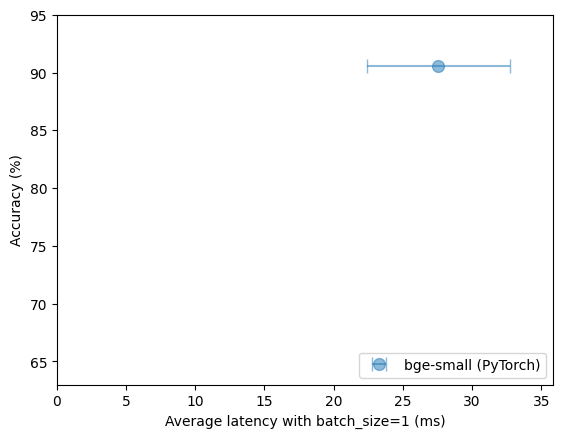

In [3]:
import json
from setfit import SetFitModel

small_model = SetFitModel.from_pretrained("moshew/bge-small-en-v1.5_setfit-sst2-english")
pb = PerformanceBenchmark(model=small_model, dataset=test_dataset, optim_type="bge-small (PyTorch)")
perf_metrics = pb.run_benchmark()

# Save the benchmark results to file
with open("baseline_metrics.json", "w") as f:
    json.dump(perf_metrics, f)
plot_metrics(perf_metrics)

## 2. Optimizing with [`optimum-intel`](https://github.com/huggingface/optimum-intel)

🤗 Optimum Intel is the interface between the 🤗 Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures.

In order to optimize our SetFit model, we'll use Intel [Neural Compressor](https://www.intel.com/content/www/us/en/developer/tools/oneapi/neural-compressor.html) (`INC`), part of `optimum-intel`. 
We'll use INC to quantize the model body. This will compress the model in size and result in faster inference. 

First, let's load the Qasper calibration dataset which we'll use for the quantization process:

In [6]:
import random
from datasets import Dataset, load_dataset

def load_qasper_calibration_set(sample_size) -> Dataset:
    train_set = load_dataset("allenai/qasper")["train"]
    random.seed(666)
    random_samples = random.sample(range(len(train_set)), sample_size)
    random_queries = [random.sample(train_set[x]["qas"]["question"], 1)[0] for x in random_samples]
    random_abstracts = [train_set[x]["abstract"] for x in random_samples]
    samples = random.sample(random_queries + random_abstracts, sample_size)
    random.shuffle(samples)
    def gen():
        for s in samples:
            yield {"text": s}
    return Dataset.from_generator(gen)

Define the desired quantization process using `optimum.intel`:

In [7]:
import warnings
import os

import optimum.intel
from neural_compressor.config import PostTrainingQuantConfig
from transformers import AutoModel, AutoTokenizer

warnings.filterwarnings("ignore")

def quantize(model_name, output_path, calibration_set):
    model = AutoModel.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def preprocess_function(examples):
        return tokenizer(examples["text"], padding="max_length", max_length=512, truncation=True)

    vectorized_ds = calibration_set.map(preprocess_function, num_proc=10)
    vectorized_ds = vectorized_ds.remove_columns(["text"])

    quantizer = optimum.intel.INCQuantizer.from_pretrained(model)
    quantization_config = PostTrainingQuantConfig(approach="static", backend="ipex", domain="nlp")
    quantizer.quantize(
        quantization_config=quantization_config,
        calibration_dataset=vectorized_ds,
        save_directory=output_path,
        batch_size=1,
    )
    tokenizer.save_pretrained(output_path)
    
model_name = "moshew/bge-small-en-v1.5_setfit-sst2-english"
calibration_set = load_qasper_calibration_set(sample_size=100)
optimum_model_path = os.path.expanduser(f"~/models/{model_name}_opt")

Quantize our SetFit model using `optimum-intel` on 100 samples:

In [8]:
quantize(model_name, output_path=optimum_model_path, calibration_set=calibration_set)

ONNX export is no supported for model with quantized embeddings
2024-01-30 00:58:04 [INFO] Start auto tuning.
2024-01-30 00:58:04 [INFO] Execute the tuning process due to detect the evaluation function.
2024-01-30 00:58:04 [INFO] Adaptor has 5 recipes.
2024-01-30 00:58:04 [INFO] 0 recipes specified by user.
2024-01-30 00:58:04 [INFO] 3 recipes require future tuning.
2024-01-30 00:58:05 [WARNING] Fail to remove /home/sdp/dkorat/setfit/notebooks/nc_workspace/2024-01-30_00-53-59/ipex_config_tmp.json.
2024-01-30 00:58:05 [INFO] *** Initialize auto tuning
2024-01-30 00:58:05 [INFO] {
2024-01-30 00:58:05 [INFO]     'PostTrainingQuantConfig': {
2024-01-30 00:58:05 [INFO]         'AccuracyCriterion': {
2024-01-30 00:58:05 [INFO]             'criterion': 'relative',
2024-01-30 00:58:05 [INFO]             'higher_is_better': True,
2024-01-30 00:58:05 [INFO]             'tolerable_loss': 0.01,
2024-01-30 00:58:05 [INFO]             'absolute': None,
2024-01-30 00:58:05 [INFO]             'keys': 

Define a SetFit model wrapper which replaces the standard model body with the optimized model body:

In [3]:
from setfit.exporters.utils import mean_pooling

class OptimumSetFitModel:
    def __init__(self, inc_model, tokenizer, model_head):
        self.optimum_model = inc_model
        self.tokenizer = tokenizer
        self.model_head = model_head

    def predict(self, inputs):
        encoded_inputs = self.tokenizer(
            inputs, padding=True, truncation=True, return_tensors="pt"
        ).to(self.optimum_model.device)

        outputs = self.optimum_model(**encoded_inputs)
        embeddings = mean_pooling(
            outputs["last_hidden_state"], encoded_inputs["attention_mask"]
        )
        return self.model_head.predict(embeddings.cpu())

    def __call__(self, inputs):
        return self.predict(inputs)

Load the optimized model and the test dataset, and perform some inference.

In [6]:
import json

import optimum.intel
from transformers import AutoTokenizer
from setfit import SetFitModel

tokenizer = AutoTokenizer.from_pretrained(optimum_model_path, model_max_length=512)
optimum_model = optimum.intel.INCModel.from_pretrained(optimum_model_path)
model = SetFitModel.from_pretrained("moshew/bge-small-en-v1.5_setfit-sst2-english")
optimum_setfit_model = OptimumSetFitModel(optimum_model, tokenizer, model.model_head)

# Reload test dataset
test_dataset = load_dataset("SetFit/sst2")["validation"]

# Perform inference
optimum_setfit_model(test_dataset["text"][:10])

loading configuration file /home/sdp/models/moshew/bge-small-en-v1.5_setfit-sst2-english_opt/inc_config.json
INCConfig {
  "distillation": {},
  "neural_compressor_version": "2.4.1",
  "optimum_version": "1.16.2",
  "pruning": {},
  "quantization": {
    "dataset_num_samples": 100,
    "is_static": true
  },
  "save_onnx_model": false,
  "torch_version": "2.1.2",
  "transformers_version": "4.37.2"
}

intel_extension_for_pytorch version is 2.1.100+cpu
2024-01-30 01:11:04,227 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: moshew/bge-small-en-v1.5_setfit-sst2-english
2024-01-30 01:11:05,583 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu


array([0, 0, 0, 0, 1, 1, 0, 1, 0, 1])

In [9]:
# RUN OPTIMUM BENCHMARK ONLY
pb = PerformanceBenchmark(
    optimum_setfit_model,
    test_dataset,
    "bge-small (optimum-intel)",
    model_path=optimum_model_path,
)
perf_metrics = {}
perf_metrics.update(pb.run_benchmark())
for optim_type, results in perf_metrics.items():
    s = [f"{k}: {v:.3f}" for k, v in results.items()]
    print(f"{optim_type}:\n" + "\n".join(s) + "\n")

Model size (MB) - 0.004
Accuracy on test set - 0.908
Average latency (ms) - 7.60 +\- 0.08
Average throughput with batch_size=64 (samples/second): 3246.93 +\- 472.37
Average throughput with batch_size=512 (samples/second): 2302.85 +\- 457.24
Average throughput with batch_size=8192 (samples/second): 882.14 +\- 22.32
bge-small (optimum-intel):
size_mb: 0.004
accuracy: 0.908
time_avg_ms: 7.601
time_std_ms: 0.083
throughput_avg_64: 3246.933
throughput_std_64: 472.370
throughput_avg_512: 2302.853
throughput_std_512: 457.242
throughput_avg_8192: 882.138
throughput_std_8192: 22.319



Time to run the performance benchmark on our optimized SetFit model!

In [ ]:
pb = PerformanceBenchmark(
    optimum_setfit_model,
    test_dataset,
    "bge-small (optimum-intel)",
    model_path=optimum_model_path,
)

# Load baseline benchmark results
with open("baseline_metrics.json") as f:
    perf_metrics = json.load(f)
perf_metrics.update(pb.run_benchmark())

# Print all results
print()
for optim_type, results in perf_metrics.items():
    s = [f"{k}: {v:.3f}" for k, v in results.items()]
    print(f"{optim_type}:\n" + "\n".join(s) + "\n")
    
plot_metrics(perf_metrics)

def get_latency_speedup(model_name):
    speedup = perf_metrics['bge-small (PyTorch)']['time_avg_ms'] / perf_metrics[model_name]['time_avg_ms']
    return speedup
print(f"Latency speedup for 'bge-small (optimum-intel)': {get_latency_speedup('bge-small (optimum-intel)'):.2f}x")

The latency speedup for batch size 1 is 2.66x compared to the baseline, while the accuracy is unchanged!